In [1]:
### Cargar modelo

In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [45]:
gpus = tf.config.list_physical_devices('GPU')

In [46]:
gpus

[]

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:

configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [7]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'Cars411.png')

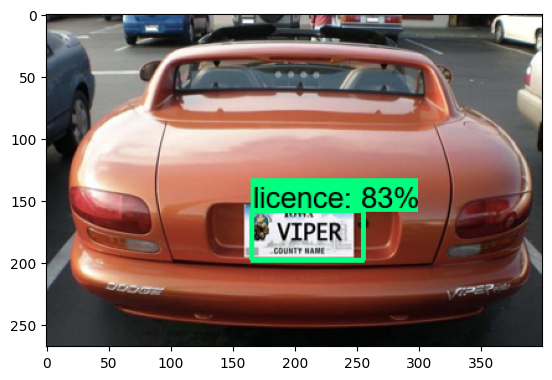

In [8]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
### Obtener el área de interes

In [10]:
detection_threshold = 0.7

In [11]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [12]:
width = image.shape[1]
height = image.shape[0]

[0.5964073  0.4146237  0.7396904  0.64027905]
[159.83715487 165.84948301 198.23703337 256.11162186]


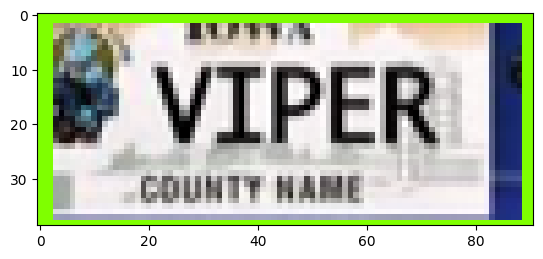

In [13]:
for idx, box in enumerate(boxes):
    print(box)
    plate = box*[height, width, height, width]
    print(plate)
    region = image[int(plate[0]):int(plate[2]),int(plate[1]):int(plate[3])]
    plt.imshow(region)

In [14]:
### Easy-OCR

In [15]:
!pip install easyocr

     ---------------------------------------- 2.9/2.9 MB 6.3 MB/s eta 0:00:00
     ---------------------------------------- 94.3/94.3 kB ? eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 11.4 MB/s eta 0:00:00
     ---------------------------------------- 35.0/35.0 MB 4.8 MB/s eta 0:00:00
     ---------------------------------------- 12.1/12.1 MB 6.2 MB/s eta 0:00:00
     -------------------------------------- 161.9/161.9 MB 4.7 MB/s eta 0:00:00
     -------------------------------------- 292.6/292.6 kB 6.0 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 6.7 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 7.2 MB/s eta 0:00:00
     ------------------------------------- 178.9/178.9 kB 11.2 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.9.2 requires google-api-python-client>=1.6.7, which is not installed.
tf-models-official 2.9.2 requires kaggle>=1.3.9, which is not installed.
tf-models-official 2.9.2 requires oauth2client, which is not installed.
tf-models-official 2.9.2 requires py-cpuinfo>=3.3.0, which is not installed.
tf-models-official 2.9.2 requires pycocotools, which is not installed.
tf-models-official 2.9.2 requires sacrebleu, which is not installed.
tf-models-official 2.9.2 requires sentencepiece, which is not installed.
tf-models-official 2.9.2 requires seqeval, which is not installed.
tf-models-official 2.9.2 requires tensorflow-datasets, which is not installed.
tf-models-official 2.9.2 requires tensorflow-hub>=0.6.0, which is not installed.
tf-models-official 2.9.2 requires tensorflow-model-optimization>=0.4.1, 

In [16]:
pip list

Package                      Version     Editable project location
---------------------------- ----------- ------------------------------------------------------------------------------------------------------------------------------
absl-py                      1.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
astunparse                   1.6.3
attrs                        22.1.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       5.0.1
cachetools                   5.2.0
certifi                      2022.6.15.1
cffi                         1.15.1
charset-normalizer           2.1.1
colorama                     0.4.5
cycler                       0.11.0
Cython                       0.29.32
debugpy                      1.6.3
decorator                    5.1.1
defusedxml                   0.7.1
easyocr                      1.6.2
entrypoints                  0.4
fastjsonschema               2.16.1
flatbuffers      

In [17]:
import easyocr

In [18]:
detection_threshold = 0.7

In [19]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [20]:
width = image.shape[1]
height = image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.5964073  0.4146237  0.7396904  0.64027905]
[159.83715487 165.84948301 198.23703337 256.11162186]
Progress: |██████████████████████████████████████████████████| 100.0% Complete


Progress: |--------------------------------------------------| 0.0% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.1% Complete
Progress: |--------------------------------------------------| 0.2% Complete
Progress: |--------------------------------------------------| 0.2% Complete
Progress: |--------------------------------------------------| 0.3% Complete
Progress: |--------------------------------------------------| 0.4% Complete
Progress: |--------------------------------------------------| 0.4% Complete
Progress: |--------------------------------------------------| 0.5% Complete
Progress: |--------------------------------------------------| 0.5% Complete
Progress: |--------------------------------------------------| 0.6% Complete
Progress: |--------------------------------------------------| 0.6% Complete
Progress: |--------------------------------------------------| 0.7% Complet


Progress: |███-----------------------------------------------| 7.5% Complete
Progress: |███-----------------------------------------------| 7.6% Complete
Progress: |███-----------------------------------------------| 7.6% Complete
Progress: |███-----------------------------------------------| 7.7% Complete
Progress: |███-----------------------------------------------| 7.8% Complete
Progress: |███-----------------------------------------------| 7.8% Complete
Progress: |███-----------------------------------------------| 7.9% Complete
Progress: |███-----------------------------------------------| 7.9% Complete
Progress: |███-----------------------------------------------| 8.0% Complete
Progress: |████----------------------------------------------| 8.1% Complete
Progress: |████----------------------------------------------| 8.1% Complete
Progress: |████----------------------------------------------| 8.2% Complete
Progress: |████----------------------------------------------| 8.2% Complet


Progress: |████████████████████████--------------------------| 48.6% Complete
Progress: |████████████████████████--------------------------| 48.7% Complete
Progress: |████████████████████████--------------------------| 48.7% Complete
Progress: |████████████████████████--------------------------| 48.8% Complete
Progress: |████████████████████████--------------------------| 48.8% Complete
Progress: |████████████████████████--------------------------| 48.9% Complete
Progress: |████████████████████████--------------------------| 49.0% Complete
Progress: |████████████████████████--------------------------| 49.0% Complete
Progress: |████████████████████████--------------------------| 49.1% Complete
Progress: |████████████████████████--------------------------| 49.1% Complete
Progress: |████████████████████████--------------------------| 49.2% Complete
Progress: |████████████████████████--------------------------| 49.2% Complete
Progress: |████████████████████████--------------------------| 

Progress: |██████████████████████████████████████████████████| 100.0% Complete[([[16, 4], [78, 4], [78, 30], [16, 30]], 'VIPER', 0.9998383031153893)]


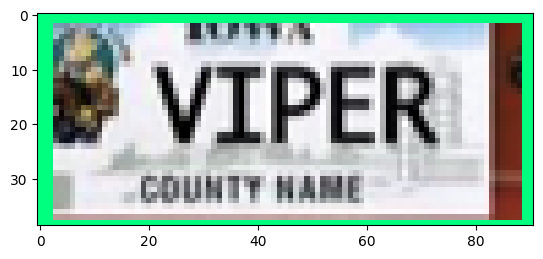

In [21]:
for idx, box in enumerate(boxes):
    print(box)
    placa = box*[height, width, height, width]
    print(placa)
    region = image[int(placa[0]):int(placa[2]),int(placa[1]):int(placa[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))   

In [22]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

26
VIPER


In [23]:
### Filtrado de textos encontrados

In [24]:
region_threshold = 0.05

In [25]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [26]:
filter_text(region, ocr_result, region_threshold)

['VIPER']